In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import seaborn as sns
import datetime
from   sklearn.model_selection import cross_val_score, train_test_split
from   sklearn.decomposition import TruncatedSVD
from   sklearn.feature_extraction.text import TfidfVectorizer
from   sklearn.feature_extraction.text import CountVectorizer
from   sklearn.feature_selection import SelectKBest, mutual_info_classif
from   sklearn.linear_model import LogisticRegression, LinearRegression
from   sklearn.model_selection import cross_val_score
from   sklearn.preprocessing import StandardScaler
from   sklearn.decomposition import LatentDirichletAllocation
from   sklearn.model_selection import GridSearchCV
from   sklearn.pipeline import Pipeline

In [2]:
songs = pd.read_csv('songs.csv')

In [3]:
songs=songs.iloc[:,1:]
print('number of songs scraped from Billboard and Genius (includes duplicates):', len(songs))
songs.head()

number of songs scraped from Billboard and Genius (includes duplicates): 262303


,rank,date,title,artist1,artist2,peak_pos,wks_chart,b_url,g_url,lyrics
0,1,1960-01-04,El Paso,Marty Robbins,NaN,1,9,https://www.billboard.com/charts/hot-100/1960-...,https://www.genius.com/Marty-Robbins-El-Paso-l...,Out in the West Texas town of El PasoI fell in...
1,2,1960-01-04,Why,Frankie Avalon,NaN,1,7,https://www.billboard.com/charts/hot-100/1960-...,https://www.genius.com/Frankie-Avalon-Why-lyrics,I'll never let you goWhy? Because I love youI'...
2,4,1960-01-04,Running Bear,Johnny Preston,NaN,4,12,https://www.billboard.com/charts/hot-100/1960-...,https://www.genius.com/Johnny-Preston-Running-...,"On the bank of the riverStood Running Bear, yo..."
3,6,1960-01-04,Heartaches By The Number,Guy Mitchell,NaN,1,14,https://www.billboard.com/charts/hot-100/1960-...,https://www.genius.com/Guy-Mitchell-Heartaches...,"Heartaches by the number, troubles by the scor..."
4,7,1960-01-04,It's Time To Cry,Paul Anka,NaN,4,7,https://www.billboard.com/charts/hot-100/1960-...,https://www.genius.com/Paul-Anka-Its-Time-To-C...,"When somebody leaves you, that's the time to c..."


In [4]:
## EDA

# add a year column to dataframe using date column
songs['year'] = songs['date'].str[0:4]

# drop duplicates and na values
songs_trun=songs[['artist1', 'lyrics', 'g_url']].drop_duplicates()
songs_trun.dropna(inplace=True)

# add year column to dataframe without duplicates
same_songs = songs.groupby('g_url')
years = pd.DataFrame(round(same_songs.year.median()))
songs_trun=songs_trun.merge(years, on='g_url')

# add decades column
songs['decade'] = (songs['year'].str[0:3].astype(int))*10

songs_trun['decade']=songs_trun['year'].astype(str)
songs_trun['decade'] = (songs_trun['decade'].str[0:3].astype(int))*10

In [5]:
print('number of unique songs scraped:', len(songs_trun))
songs_trun.head()

number of unique songs scraped: 22038


,artist1,lyrics,g_url,year,decade
0,Marty Robbins,Out in the West Texas town of El PasoI fell in...,https://www.genius.com/Marty-Robbins-El-Paso-l...,1960.0,1960
1,Frankie Avalon,I'll never let you goWhy? Because I love youI'...,https://www.genius.com/Frankie-Avalon-Why-lyrics,1960.0,1960
2,Johnny Preston,"On the bank of the riverStood Running Bear, yo...",https://www.genius.com/Johnny-Preston-Running-...,1960.0,1960
3,Guy Mitchell,"Heartaches by the number, troubles by the scor...",https://www.genius.com/Guy-Mitchell-Heartaches...,1960.0,1960
4,Paul Anka,"When somebody leaves you, that's the time to c...",https://www.genius.com/Paul-Anka-Its-Time-To-C...,1960.0,1960


In [6]:
# Vectorize for the sake of SVD 

        # need to find optimal vectorizer
    
    
vectorizer = CountVectorizer( #token counts
    input = 'content',
    encoding = 'utf-8',
    strip_accents = 'unicode',
    #stop_words='english', 
    lowercase = True,
    min_df = 0.1, #chunk by song
    max_df = 0.9    
)

X = vectorizer.fit_transform(songs_trun['lyrics'])
print("Feature matrix shape:", X.shape)
print("Total vectorized words in the corpus:", X.sum())
print("Average vectorized song length:", int(X.sum()/X.shape[0]), "tokens")

Feature matrix shape: (22038, 156)
Total vectorized words in the corpus: 3218565
Average vectorized song length: 146 tokens


In [7]:
def remove_noninformative_tokens(doc):
    '''
    Takes a spacy-processed document.
    Returns a list of spacy token objects without stopwords, punctuation, or embedding-less tokens.
    '''
    culled = [token for token in doc if not (token.is_stop or token.is_punct or token.is_space) and token.has_vector]
    return(culled)

def get_doc_embedding(text, nlp):
    '''
    Takes a document as a text string and a loaded spaCy nlp object.
    Returns a vector representation of the document.
    '''
    doc = nlp(text)
    culled = remove_noninformative_tokens(doc)
    embedding = np.mean([token.vector for token in culled], axis=0)
    if np.isnan(embedding).any():
        embedding = np.zeros([1,nlp.vocab.vectors_length])
        print(f"There was a problem with document {i}\nText: {text}\n")
    return(embedding)

In [8]:
%%time
# Vectorize embeddings
import spacy
import datetime
nlp = spacy.load("en_core_web_lg")

X_embed = np.zeros([len(songs_trun), nlp.vocab.vectors_length])
for i, text in enumerate(songs_trun.lyrics):
    if i%1000 == 0:
        print(f'{i:<5} documents processed @ {datetime.datetime.now()}')
    X_embed[i] = get_doc_embedding(text, nlp)
print(X_embed.shape)

0     documents processed @ 2022-05-19 00:50:27.346128
1000  documents processed @ 2022-05-19 00:51:06.189053


/Users/gabychu/opt/anaconda3/envs/3350/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/gabychu/opt/anaconda3/envs/3350/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


There was a problem with document 1228
Text: 上を向いて歩こう涙がこぼれないように思い出す春の日一人ぼっちの夜上を向いて歩こうにじんだ星を数えて思い出す夏の日一人ぼっちの夜幸せは雲の上に幸せは空の上に上を向いて歩こう涙がこぼれないように泣きながら歩く一人ぼっちの夜*Whistling*思い出す秋の日一人ぼっちの夜悲しみは星の影に悲しみは月の影に上を向いて歩こう涙がこぼれないように泣きながら歩く一人ぼっちの夜一人ぼっちの夜*Whistling*

2000  documents processed @ 2022-05-19 00:51:54.935558
There was a problem with document 2760
Text: Woo!Hey, yeah!One more timeYeah!

3000  documents processed @ 2022-05-19 00:52:36.123197
4000  documents processed @ 2022-05-19 00:53:15.215968
There was a problem with document 4591
Text: MandrillMandrillMandrillMandrillMandrill

5000  documents processed @ 2022-05-19 00:53:57.205664
6000  documents processed @ 2022-05-19 00:54:51.922025
7000  documents processed @ 2022-05-19 00:56:09.238722
8000  documents processed @ 2022-05-19 00:57:37.184070
9000  documents processed @ 2022-05-19 00:58:31.805044
10000 documents processed @ 2022-05-19 00:59:27.972842
11000 documents processed @ 2022-05-19 01:00:20.686512
There was a problem with document 113

In [ ]:
# code adapted from: lect 24 neural methods

In [ ]:
%%time
# grid search for optimal classification parameters
logreg = LogisticRegression()
params = {
    'penalty': ['l1', 'l2', 'none', 'elastic'],
    'solver':['saga'],
    'max_iter':[2000] # not part of the search, but set a classifier parameter
}
clf = GridSearchCV(logreg, params, n_jobs=-1)

# work with a subset of the data, to speed things up
X_train, X_test, y_train, y_test = train_test_split(X_embed, songs_trun['decade'], train_size = 2000)

# perform grid search
with warnings.catch_warnings() as w:
    warnings.simplefilter("ignore")
    clf.fit(X_train, y_train) # Note subset of the data!

In [ ]:
# find the best parameters to use
clf.best_params_

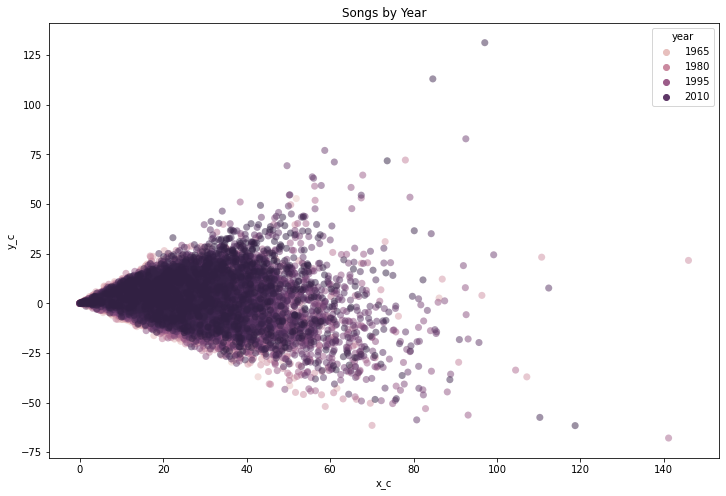

In [83]:
# first, some data vis


# by year
song_vis = TruncatedSVD(n_components=2).fit_transform(X)

songs_trun['x_c']=song_vis[:,0]
songs_trun['y_c']=song_vis[:,1]

plt.subplots(figsize=(12,8))
sns.scatterplot(
    x=songs_trun['x_c'], 
    y=songs_trun['y_c'],
    hue=songs_trun['year'],
    #style=books_order['shape'],
    alpha=0.5,
    s=50,
    linewidth=0
)
plt.title('Songs by Year')
plt.show()

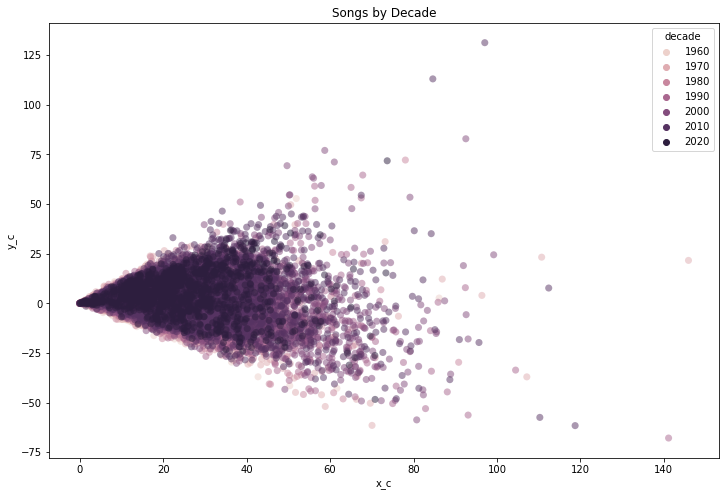

In [84]:
# by decade
song_vis = TruncatedSVD(n_components=2).fit_transform(X)

songs_trun['x_c']=song_vis[:,0]
songs_trun['y_c']=song_vis[:,1]

plt.subplots(figsize=(12,8))
sns.scatterplot(
    x=songs_trun['x_c'], 
    y=songs_trun['y_c'],
    hue=songs_trun['decade'],
    #style=books_order['shape'],
    alpha=0.5,
    s=50,
    linewidth=0
)
plt.title('Songs by Decade')
plt.show()

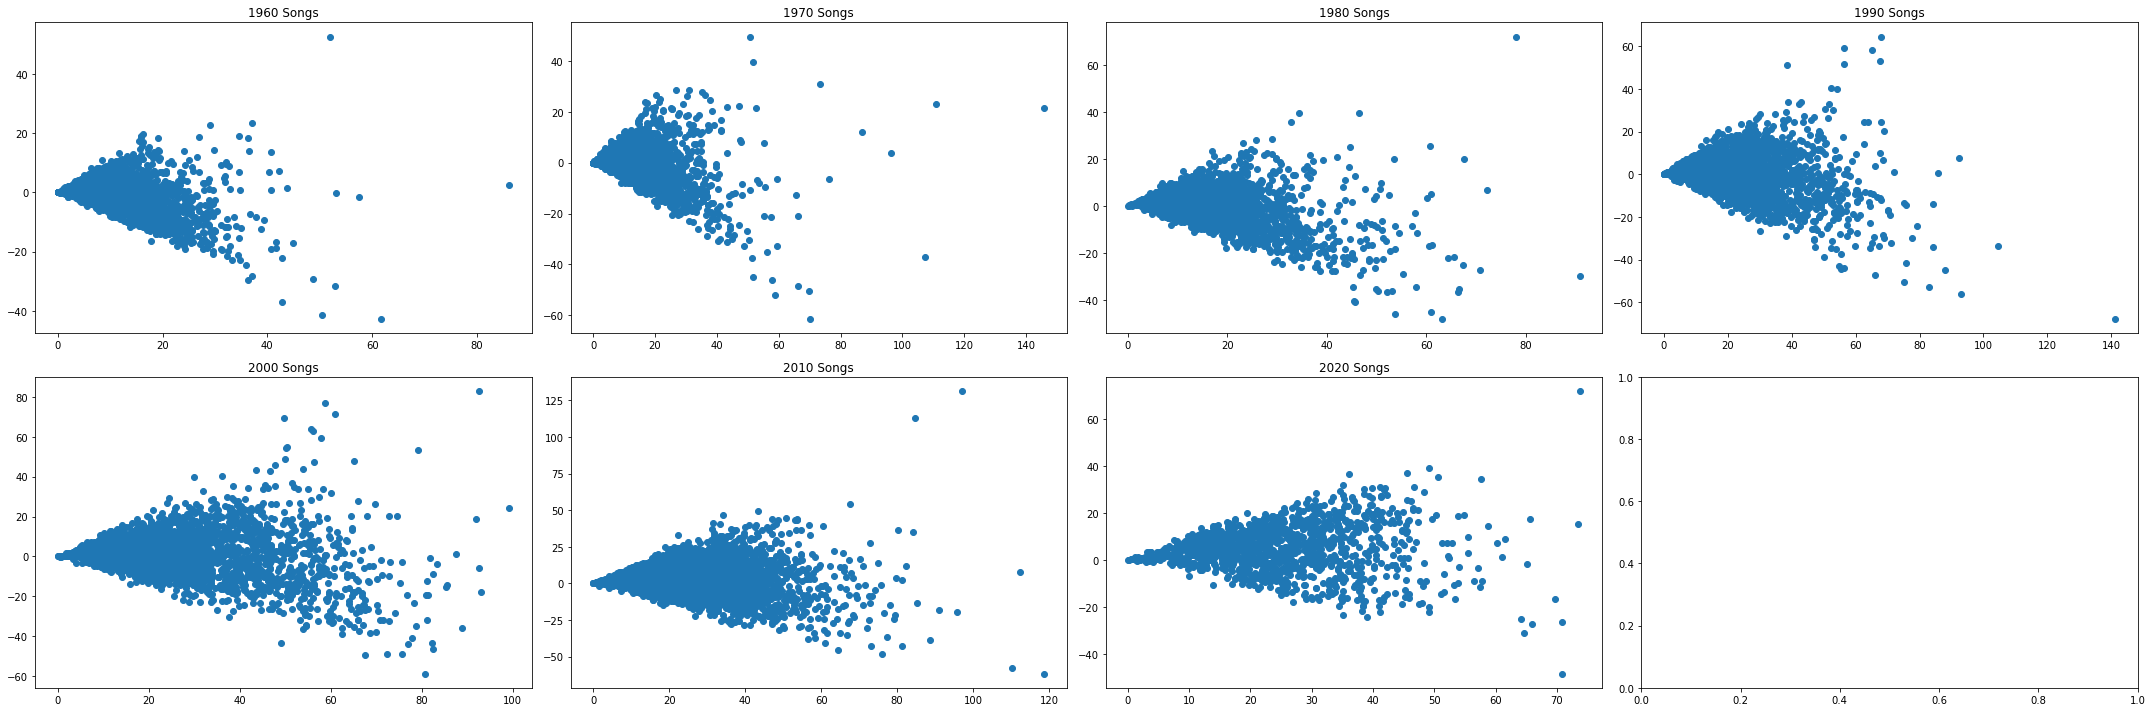

In [86]:
# separate each decade

x=0
fig, axs = plt.subplots(2, 4, figsize=(30,10))
axs = axs.ravel()
for decade in sorted(songs_trun['decade'].unique()):
    axs[x].scatter(songs_trun[songs_trun.decade == decade]['x_c'], songs_trun[songs_trun.decade == decade]['y_c'])
    axs[x].set_title(f'{decade} Songs')
    x+=1
plt.tight_layout()
plt.show()

resources
- https://towardsdatascience.com/logistic-regression-model-tuning-with-scikit-learn-part-1-425142e01af5
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html